# 준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/modeling/data/kakao_data/ratings_two.csv')
ratings = ratings[['user_id', 'cafe', 'rating']]
ratings['rating'] = ratings['rating'].astype(int)           # timestamp 제거

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# model train/test

In [ ]:
# train test 분리

from sklearn.utils import shuffle
TRAIN_SIZE = 0.7
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

# New MF class for training & testing
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
##### >>>>> (2) user_id, item_id를 R의 index와 매핑하기 위한 dictionary 생성
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings): # 각 열에 대해서 iterate. 우리의 input 자체가 user-cafe matrix임
            item_id_index.append([one_id, i]) #카페이름 - 그에 따른 번호 index 두 원소를 list로
            index_item_id.append([i, one_id]) #번호 - 카페 이름 index 두 원소를 list로
        self.item_id_index = dict(item_id_index) # 딕셔너리화
        self.index_item_id = dict(index_item_id) # 딕셔너리화

        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T): # 행에 대해서 iterate. transpose 했기에...
            user_id_index.append([one_id, i]) #사람id - 그에 따른 번호 index 두 원소를 list로
            index_user_id.append([i, one_id]) #번호 - 사람id index 두 원소를 list로
        self.user_id_index = dict(user_id_index) #딕셔너리화
        self.index_user_id = dict(index_user_id) #딕셔너리화
#### <<<<< (2)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K #K는 특징 개수, 즉 latent 개수임
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose #구구절절 출력할거냐?

    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero() #0이 아닌 값들의 인덱스 반환. 행-열 순서로 반환하는 듯.
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y) # 값들 있는 인덱스에 대해서 prediction 진행.
            self.predictions.append(prediction) # 자기 자신에 대한 예측값 저장하기
            self.errors.append(self.R[x, y] - prediction) # 자기자신에 대한 예측값 - 자기자신 error 저장하기
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2)) # rmse 계산식
        # 그러니까 여기서 주는 rmse는 사실 많은 개수가 아닐 수도 있는 것임. 
        # 30%를 똑 떼어다가 값이 있는 것들로만 prediction한 걸 가지고 계산한 것이니까...

    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
        # 아래에서 b가 뭔지 나오겠지 머...
        # 내적하고 bias 더하는 식으로 구성되는 듯?

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            # 업데이트 과정인 거 같은데...
            # 그냥 b는 업데이트 안하는 군
            # 근데 왜 업데이트를 이렇게 하는거냐 - full prediction() 참고해서 행렬 미분해보기

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

##### >>>>> (3)
    # Test set을 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):      # test 데이터에 있는 각 데이터에 대해서
            x = self.user_id_index[ratings_test.iloc[i, 0]] #이거는 userid 뽑아서 user-cafe matrix에서 찾으려고 하는 것인듯
            y = self.item_id_index[ratings_test.iloc[i, 1]] #이거는 cafe   뽑아서 user-cafe matrix에서 찾으려고 하는 것인듯
            z = ratings_test.iloc[i, 2] # 이거는 rating
            test_set.append([x, y, z])
            self.R[x, y] = 0                    # Setting test set ratings to 0
            # 왜냐면 우리가 알고싶은 것 자체를 학습시키면 그냥 그 답을 얻어낼 것이기 때문임.
        self.test_set = test_set
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:#one_set에는 [0] 열이 user [1] 열이 cafe [2]열이 rating
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)# 뭔가 얘는 array가 아닌가보다
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K)) # 무한대로 갈까봐 일단 K로 스케일..
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users) #user에 대한 bias # 음 이걸 대체해줄 수도 있을 것 같고..
        self.b_d = np.zeros(self.num_items) #item에 대한 bias
        self.b = np.mean(self.R[self.R.nonzero()]) #0이 아닌 경우의 값의 평균

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations): #반복수만큼
            np.random.shuffle(self.samples) #우리가 이미 가지고 있는 sample을 섞어준다.
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)




In [ ]:
##### <<<<< (3)

# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='cafe', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=300, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

# Printing predictions
print(mf.full_prediction())

Iteration: 10 ; Train RMSE = 1.3658 ; Test RMSE = 1.3894
Iteration: 20 ; Train RMSE = 1.3181 ; Test RMSE = 1.3668
Iteration: 30 ; Train RMSE = 1.2775 ; Test RMSE = 1.3498
Iteration: 40 ; Train RMSE = 1.2420 ; Test RMSE = 1.3363
Iteration: 50 ; Train RMSE = 1.2105 ; Test RMSE = 1.3255
Iteration: 60 ; Train RMSE = 1.1820 ; Test RMSE = 1.3165
Iteration: 70 ; Train RMSE = 1.1561 ; Test RMSE = 1.3091
Iteration: 80 ; Train RMSE = 1.1323 ; Test RMSE = 1.3028
Iteration: 90 ; Train RMSE = 1.1104 ; Test RMSE = 1.2974
Iteration: 100 ; Train RMSE = 1.0900 ; Test RMSE = 1.2927
Iteration: 110 ; Train RMSE = 1.0709 ; Test RMSE = 1.2887
Iteration: 120 ; Train RMSE = 1.0530 ; Test RMSE = 1.2852
Iteration: 130 ; Train RMSE = 1.0362 ; Test RMSE = 1.2822
Iteration: 140 ; Train RMSE = 1.0202 ; Test RMSE = 1.2796
Iteration: 150 ; Train RMSE = 1.0051 ; Test RMSE = 1.2773
Iteration: 160 ; Train RMSE = 0.9907 ; Test RMSE = 1.2752
Iteration: 170 ; Train RMSE = 0.9769 ; Test RMSE = 1.2735
Iteration: 180 ; Train 

In [ ]:
print(mf.get_one_prediction('100ck0j', '할리스커피 응암역점 신사동'))
# user '100ck0j'의 할리스커피 응암역점 신사동에 대한 점수 예측값

4.131889035509256


# 최적의 값 찾기

K = 10
Iteration: 10 ; Train RMSE = 1.3644 ; Test RMSE = 1.3898
Iteration: 20 ; Train RMSE = 1.3151 ; Test RMSE = 1.3674
Iteration: 30 ; Train RMSE = 1.2729 ; Test RMSE = 1.3504
Iteration: 40 ; Train RMSE = 1.2358 ; Test RMSE = 1.3370
Iteration: 50 ; Train RMSE = 1.2027 ; Test RMSE = 1.3262
Iteration: 60 ; Train RMSE = 1.1727 ; Test RMSE = 1.3174
Iteration: 70 ; Train RMSE = 1.1453 ; Test RMSE = 1.3100
Iteration: 80 ; Train RMSE = 1.1200 ; Test RMSE = 1.3037
Iteration: 90 ; Train RMSE = 1.0964 ; Test RMSE = 1.2984
Iteration: 100 ; Train RMSE = 1.0744 ; Test RMSE = 1.2938
Iteration: 110 ; Train RMSE = 1.0537 ; Test RMSE = 1.2898
Iteration: 120 ; Train RMSE = 1.0341 ; Test RMSE = 1.2864
Iteration: 130 ; Train RMSE = 1.0154 ; Test RMSE = 1.2834
Iteration: 140 ; Train RMSE = 0.9976 ; Test RMSE = 1.2808
Iteration: 150 ; Train RMSE = 0.9805 ; Test RMSE = 1.2785
Iteration: 160 ; Train RMSE = 0.9641 ; Test RMSE = 1.2765
Iteration: 170 ; Train RMSE = 0.9482 ; Test RMSE = 1.2748
Iteration: 180 ;

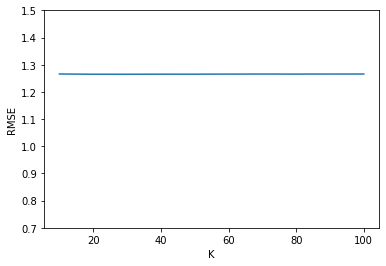

In [ ]:
##### <<<<< (3)

# 최적의 K값 찾기
results = []
index = []
for K in range(10, 101, 10):
    print('K =', K)
    R_temp = ratings.pivot(index='user_id', columns='cafe', values='rating').fillna(0)
    mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.02, iterations=300, verbose=True)
    test_set = mf.set_test(ratings_test)
    result = mf.test()
    index.append(K)
    results.append(result)

# 최적의 iterations 값 찾기
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j+1, RMSE[j]])

# 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(index, [x[2] for x in summary])
plt.ylim(0.7, 1.5)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()



# Predict

In [ ]:
##### (1)

# MF class
class MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # Root Mean Squared Error (RMSE) 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    def train(self): 
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i+1, rmse))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f " % (i+1, rmse))
        return training_process

    # Rating prediction for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    # 아래 함수 참고해서 추가하였음. 이걸로 우리는 그냥 predict 하면 되니까..
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])




In [ ]:
# 전체 데이터 사용 MF
R_temp = ratings.pivot(index='user_id', columns='cafe', values='rating').fillna(0) #얘 왜 0으로 채우지
mf = MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=300, verbose=True)
train_process = mf.train()

Iteration: 10 ; Train RMSE = 1.3540 
Iteration: 20 ; Train RMSE = 1.3019 
Iteration: 30 ; Train RMSE = 1.2594 
Iteration: 40 ; Train RMSE = 1.2234 
Iteration: 50 ; Train RMSE = 1.1921 
Iteration: 60 ; Train RMSE = 1.1643 
Iteration: 70 ; Train RMSE = 1.1394 
Iteration: 80 ; Train RMSE = 1.1168 
Iteration: 90 ; Train RMSE = 1.0962 
Iteration: 100 ; Train RMSE = 1.0772 
Iteration: 110 ; Train RMSE = 1.0595 
Iteration: 120 ; Train RMSE = 1.0431 
Iteration: 130 ; Train RMSE = 1.0277 
Iteration: 140 ; Train RMSE = 1.0132 
Iteration: 150 ; Train RMSE = 0.9994 
Iteration: 160 ; Train RMSE = 0.9863 
Iteration: 170 ; Train RMSE = 0.9738 
Iteration: 180 ; Train RMSE = 0.9617 
Iteration: 190 ; Train RMSE = 0.9500 
Iteration: 200 ; Train RMSE = 0.9387 
Iteration: 210 ; Train RMSE = 0.9276 
Iteration: 220 ; Train RMSE = 0.9168 
Iteration: 230 ; Train RMSE = 0.9061 
Iteration: 240 ; Train RMSE = 0.8955 
Iteration: 250 ; Train RMSE = 0.8850 
Iteration: 260 ; Train RMSE = 0.8745 
Iteration: 270 ; Trai

In [ ]:
columns = R_temp.columns
index = R_temp.index
df_sgd_preds = pd.DataFrame(mf.full_prediction(), index=index, columns=columns)
df_sgd_preds.head()

cafe,0125커피바 홍은동,044워리어스 당산동1가,089커피앤베이커리 화곡동,1028커피엔디저트 성내동,10인치샌드위치&커피 봉천동,125coffee 갈현동,139COFFEE 전농동,1980벽돌집 신정동,1월의윤슬 내발산동,205도씨 명륜2가,...,히어로보드게임카페 홍대2호점 동교동,히어로스터 신도림동,히어커피 양재동,히얼스유알커피 삼성동,히자우 홍제동,히포커피 대학동점 신림동,히포커피서울대점 서울대점 신림동,히히냥냥 역삼동,힐브레드 마곡동,힘들땐마카롱 신당동
user_id,,,,,,,,,,,,,,,,,,,,,
100bln7,4.418648,4.701707,4.038430,4.414872,4.478813,4.196161,4.318218,4.074968,4.608485,3.675981,...,4.173944,3.670110,4.527060,4.428218,4.463158,4.601887,3.005097,4.642895,4.633465,4.630757
100ck0j,3.418764,3.673722,3.019985,3.366880,3.450275,3.162869,3.276047,3.047911,3.606718,2.627865,...,3.135087,2.619773,3.494889,3.392777,3.448092,3.573710,2.003862,3.597655,3.618360,3.598185
100i22n,3.443187,3.729595,3.065506,3.427235,3.482358,3.226143,3.325007,3.092314,3.621694,2.683060,...,3.193897,2.681142,3.538707,3.434108,3.460773,3.601079,2.056723,3.644156,3.659086,3.645042
100ooji,4.634503,4.923649,4.220207,4.615035,4.686915,4.400035,4.534823,4.272445,4.819267,3.903943,...,4.372669,3.859947,4.735416,4.629263,4.671798,4.800215,3.244150,4.855130,4.842724,4.837402
100q04c,4.259201,4.555874,3.916948,4.260553,4.327703,4.042947,4.169073,3.903287,4.442949,3.548511,...,4.076016,3.523729,4.382127,4.264374,4.299693,4.458434,2.905443,4.481507,4.496276,4.480125


# Recommender

In [ ]:
def recommend_cafe(df_sgd_preds, user_id, ori_ratings_df, num_recommendations=5):
    
    # 최종적으로 만든 pred_df에서 사용자 index에 따라 영화 데이터 정렬 -> 영화 평점이 높은 순으로 정렬
    sorted_user_predictions = df_sgd_preds.loc[user_id,:].sort_values(ascending=False)
    
    # 원본 평점 데이터에서 user id에 해당하는 데이터를 뽑아낸다. 
    user_data = ori_ratings_df[ori_ratings_df.user_id == user_id][['cafe','rating']]
    
    # 원본 영화 데이터에서 사용자가 본 영화 데이터를 제외한 데이터를 추출

    recommendations = ori_ratings_df[~ori_ratings_df['cafe'].isin(user_data)]['cafe']

    # 사용자의 영화 평점이 높은 순으로 정렬된 데이터와 위 recommendations을 합친다. 
    recommendations = pd.DataFrame(recommendations).merge(pd.DataFrame(sorted_user_predictions),right_index = True,left_index=True,how='right')
    recommendations.drop('cafe',axis=1,inplace=True)

    # 컬럼 이름 바꾸고 정렬해서 return
    recommendations = recommendations.rename(columns = {user_id: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]
                      

    return user_data, recommendations

In [ ]:
def recommend_cafe_address(df_svd_preds, user_id, ori_ratings_df, num_recommendations=5, address='영등포구'):
    
    # 최종적으로 만든 pred_df에서 사용자 index에 따라 영화 데이터 정렬 -> 영화 평점이 높은 순으로 정렬
    sorted_user_predictions = df_svd_preds.loc[user_id,:].sort_values(ascending=False)
    
    # 원본 평점 데이터에서 user id에 해당하는 데이터를 뽑아낸다. 
    user_data = ori_ratings_df[ori_ratings_df.user_id == user_id][['cafe','rating']]
    
    # 원본 영화 데이터에서 사용자가 본 영화 데이터를 제외한 데이터를 추출

    recommendations = ori_ratings_df[~ori_ratings_df['cafe'].isin(user_data)]['cafe']


    # 사용자의 영화 평점이 높은 순으로 정렬된 데이터와 위 recommendations을 합친다. 
    recommendations = pd.DataFrame(recommendations).merge(pd.DataFrame(sorted_user_predictions),right_index = True,left_index=True,how='right')

    # 이미 갔던 곳 제외하기 위한 코드 추가
    user_data.reset_index(inplace=True, drop=True)
    for i in range(len(user_data)):
      recommendations = recommendations[recommendations.index!=user_data.loc[i,'cafe']]
    
    recommendations = pd.merge(recommendations, public_df.set_index('cafe')[['시군구명','도로명주소']], left_index=True,right_index=True,how='left')
    recommendations.drop('cafe',axis=1,inplace=True)

    ## address 부분
    recommendations = recommendations[recommendations['시군구명']==address]

    # 컬럼 이름 바꾸고 정렬해서 return
    recommendations = recommendations.rename(columns = {user_id: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]
                      

    return user_data, recommendations

In [ ]:
already_rated, predictions = recommend_cafe(df_sgd_preds, user_id='100ck0j', ori_ratings_df=ratings,num_recommendations=10)

In [ ]:
already_rated

,cafe,rating
2,공차 이대익스프레스점 대현동,1
4,폴바셋 방배역점 방배동,5
3,투썸플레이스 숙대입구역점 남영동,1


In [ ]:
predictions

,Predictions
cafe,
트래고드 도곡동,4.271951
이로리로스터스 잠실동,4.240403
오후의파이 석촌동,4.239380
할리스 태능입구역점 공릉동,4.233243
에그마카슈 성수점 성수동1가,4.225245
백씨네콩다방 회기동,4.214767
튀튀쿠키 누하동,4.208639
투썸플레이스 신대방삼거리점 상도동,4.207389
몽떼 원효로1가,4.193941


In [ ]:
already_rated, predictions = recommend_cafe_address(df_sgd_preds, user_id='10l9o2l', ori_ratings_df=ratings,num_recommendations=10,
                                                    address='서대문구')

In [ ]:
predictions

,Predictions,시군구명,도로명주소
루터커피 옥천동,4.711167,서대문구,서울특별시 서대문구 독립문로 26
증가로커피공방 남가좌동,4.677343,서대문구,서울특별시 서대문구 증가로10길 36-55
컨시어지커피 연희동,4.651650,서대문구,서울특별시 서대문구 증가로 1
원오브씨 창천동,4.640269,서대문구,서울특별시 서대문구 신촌로3길 5
스타벅스 가재울뉴타운점 남가좌동,4.583446,서대문구,서울특별시 서대문구 가재울미래로 2
산맥로스터리 북가좌동,4.536459,서대문구,서울특별시 서대문구 증가로 213
스타벅스 아현역점 북아현동,4.531679,서대문구,서울특별시 서대문구 북아현로 29
메가엠지씨커피 가재울뉴타운점 남가좌동,4.526134,서대문구,서울특별시 서대문구 가재울미래로 2
에스페란자로스터즈 홍은동,4.511756,서대문구,서울특별시 서대문구 증가로4길 58-15
벤치커피스튜디오 대현동,4.499709,서대문구,서울특별시 서대문구 연세로2마길 14
